# Projet Py - Logements

### import des biblios

In [8]:
import numpy as np
import pandas as pd
import glob
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd # pip install geopandas
import pysal as ps # conda install -c anaconda pysal= 2.1
import scipy
from scipy.spatial import KDTree
import contextily as cx
import plotly.express as px


### Problématique 
Où construit-on le plus en France?

Pour répondre à cette question, trois échelles ont été étudiées:

-régionale

-départementales

-et une étude de cas plus précise pour le département qui a été identifié comme celui où on construit le plus: loire-atlantique

### Données utilisées
Les données utilisées sont issues de la base de données sitadel qui recense tout les projets de construction en France, elle est mise à dispostion sous la forme d'un fichier csv.
Nous avons décider de nous baser sur l'année 2021.



In [9]:
sitadel=pd.read_csv('PC_DP_créant_logements_2021.txt', sep='\t', encoding='latin-1', low_memory=False)

In [10]:
sitadel.head()

,REG,DEP,COMM,Type_DAU,Num_DAU,Etat_DAU,DATE_REELLE_AUTORISATION,DATE_REELLE_DOC,DATE_REELLE_DAACT,DPC_AUT,...,SURF_HAB_AVANT,SURF_HAB_CREEE,SURF_HAB_ISSUE_TRANSFO,SURF_HAB_DEMOLIE,SURF_HAB_TRANSFORMEE,SURF_LOC_AVANT,SURF_LOC_CREEE,SURF_LOC_ISSUE_TRANSFO,SURF_LOC_DEMOLIE,SURF_LOC_TRANSFORMEE
0,82,1,1001,PC,00100120V0010,2,18/01/2021,NaN,NaN,202101,...,0.0,92.0,0.0,0.0,0.0,0,0,0,0,0
1,82,1,1001,PC,00100121V0001,5,16/03/2021,28/06/2021,NaN,202103,...,0.0,112.0,0.0,0.0,0.0,0,0,0,0,0
2,82,1,1001,PC,00100121V0002,2,02/04/2021,NaN,NaN,202104,...,0.0,0.0,142.0,0.0,0.0,142,0,0,0,142
3,82,1,1001,PC,00100121V0003,2,26/04/2021,NaN,NaN,202104,...,0.0,105.0,0.0,0.0,0.0,0,0,0,0,0
4,82,1,1001,PC,00100121V0004,5,12/05/2021,25/11/2021,NaN,202105,...,0.0,103.0,0.0,0.0,0.0,0,0,0,0,0


## Partie 1: Echelle Regionale 

### Group by region
Puis nous avons regroupé les données par région pour une comparaison à l'échelle régionale

In [11]:
reg_sitadel=sitadel[['REG', 'Num_DAU']].groupby(['REG'], as_index=False).count()

In [12]:
reg_sitadel['REG']=reg_sitadel['REG'].apply(str)

In [13]:
reg_sitadel['REG']=reg_sitadel['REG'].replace({'1': 'Guadeloupe', '2': 'Martinique', '3': 'Guyane', '4': 'La Reunion','6':'Mayotte', 
                         '11': 'Ile-de-France', '21': 'Grand Est','22': 'Haut-de-France', '23':'Normandie', 
                         '24':'Centre-Val-de-Loire','25': 'Normandie', '26':'Bourgogne-France-Comté', 
                         '31': 'Haut-de-France','41':'Grand Est', '42': 'Grand Est',
                         '43':'Bourgogne-France-Comté', '52': 'Pays de la Loire', '53':'Bretagne',
                        '54':'Nouvelle-Aquitaine', '72':'Nouvelle-Aquitaine', '73':'Occitanie',
                        '74':'Nouvelle-Aquitaine', '82':'Auvergne-Rhone-Alpes', '83':'Auvergne-Rhone-Alpes',
                        '91': 'Occitanie', '93':'Rhone-Alpes-Cote-Azur', '94': 'Corse'})

In [15]:
reg_sitadel=reg_sitadel[['REG', 'Num_DAU']].groupby(['REG'], as_index=False).sum()

In [16]:
reg_sitadel=reg_sitadel.sort_values(by=['Num_DAU'], ascending=True)

In [22]:
fig = px.bar(reg_sitadel, x='REG', y='Num_DAU',  color='REG', width=1200, height=800)


In [25]:
##fig.show()

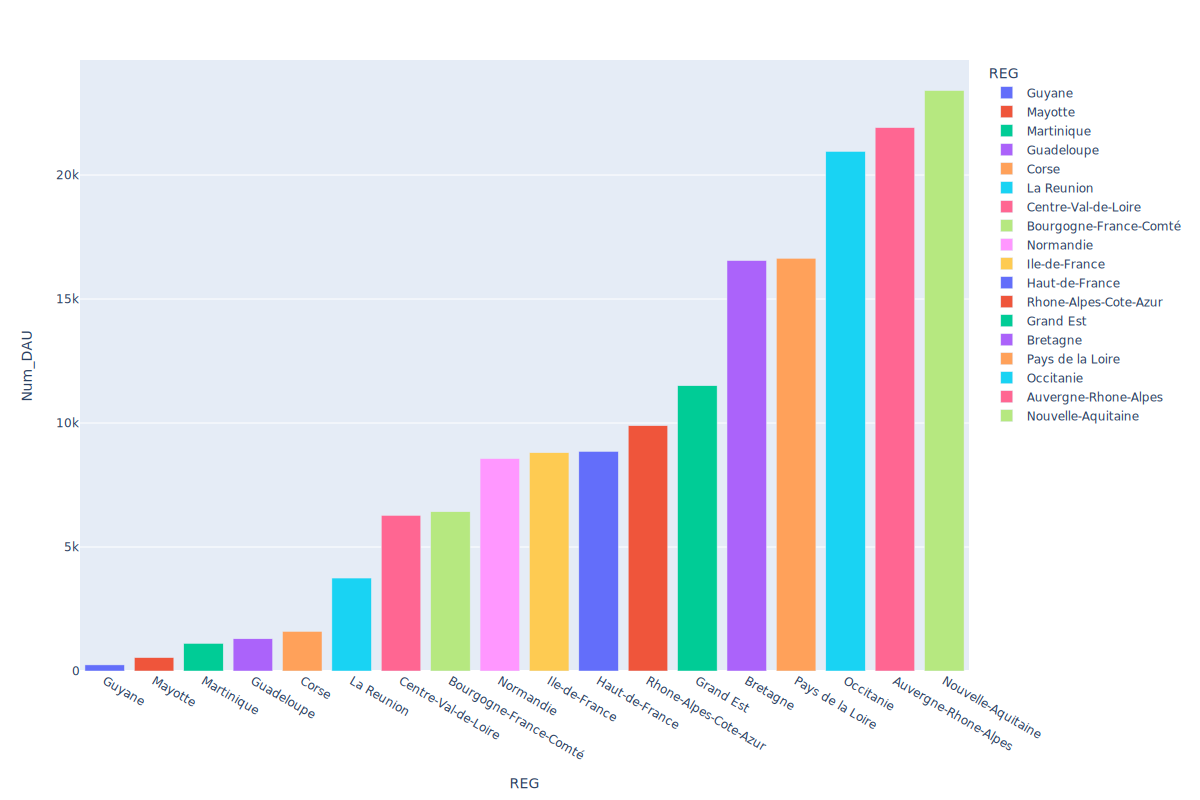

In [26]:
fig.show(renderer="svg")

## Partie 2: Echelle Departementale




### Count par nombre de demandes de permis de construire par départements

In [27]:
departement_sitadel=sitadel[['DEP', 'Num_DAU']].groupby(['DEP'], as_index=False).count()

In [28]:
dep_top=departement_sitadel.sort_values(by=['Num_DAU'], ascending=False).head(10)

In [29]:
dep_top['rank']=dep_top['Num_DAU'].rank(ascending=False, method='min')

In [30]:
dep_top

,DEP,Num_DAU,rank
39,44,6008,1.0
84,85,5820,2.0
27,33,5716,3.0
52,56,4737,4.0
29,35,4437,5.0
20,29,4302,6.0
8,17,4041,7.0
25,31,3963,8.0
28,34,3769,9.0
99,974,3748,10.0


In [31]:
dep_top10=dep_top['DEP'].tolist()

### Creation d'une liste contenant le top 10 des départements où résident le plus de demandeur de permis de construire

In [32]:
sitadel_part=sitadel[sitadel['CAT_DEM'].isin([10,11])].copy()

In [33]:
len(sitadel_part)/len(sitadel)

0.8648834915693288

In [34]:
sitadel_part['DEP_D']=sitadel_part.CODPOST_DEM.str[:2]

In [35]:
dep_origine=sitadel_part[['DEP', 'DEP_D', 'Num_DAU']].groupby(['DEP','DEP_D'], as_index=False).count()

In [36]:
dep_origine=dep_origine[dep_origine['DEP'].isin(dep_top10)]

In [37]:
dep_origine

,DEP,DEP_D,Num_DAU
311,17,,30
312,17,10,2
313,17,11,2
314,17,12,1
315,17,13,4
...,...,...,...
3793,974,94,4
3794,974,97,3210
3795,974,98,1
3796,974,SA,1


In [38]:
dep_origine['DEP_D']=np.where(dep_origine['DEP']==dep_origine['DEP_D'], 'venant du departement', dep_origine['DEP_D'])
dep_origine['DEP_D']=np.where((dep_origine['DEP']=='974') & (dep_origine['DEP_D']=='97'), 'venant du departement', dep_origine['DEP_D'])

In [39]:
dep_origine['DEP_D']=np.where(dep_origine['DEP_D']=='venant du departement', dep_origine['DEP_D'], 'autres')

In [41]:
##dep_origine.sort_values(by=['Num_DAU'], ascending=[False]).head(11)

In [25]:
##dep_origine['rank']=dep_origine['DEP'].map(dep_top.set_index('DEP')['rank'])

In [26]:
##dep_origine=dep_origine.sort_values(by=['rank'], ascending=False)

In [42]:
dep_origine=dep_origine[['DEP', 'DEP_D', 'Num_DAU']].groupby(['DEP','DEP_D'], as_index=False).sum()

In [43]:
dep_origine['rank']=dep_origine['DEP'].map(dep_top.set_index('DEP')['rank'])
dep_origine=dep_origine.sort_values(by=['rank','DEP_D'], ascending=[False,True])

In [60]:
fig = px.bar(dep_origine, x="DEP", y="Num_DAU", color="DEP_D", 
             title="Nombre de nouvelles constructions dans les 10 départements où on construit le plus en France en 2021",
            width=1000, height=600,
            labels={
                     "Num_DAU": "Nombre de construction",
                     "DEP": "Numéro du département",
                     "DEP_D": "Originie du propriétaire"
                 },
            color_discrete_map={
        'autres': '#696969',
        'venant du departement': '#6495ED'})

In [61]:
fig.show()


## Partie 3: Etude de cas extension urbaine en Loire-Atlantique


### Création d'un Geodataframe

In [31]:
dep_44=gpd.read_file(r'communes-loire-atlantique.geojson')


In [32]:
dep_44['geometry']=dep_44['geometry'].simplify(0.001)

### nombre de constructions par commune

In [33]:
com_sitadel=sitadel[['COMM', 'Num_DAU']].groupby(['COMM'], as_index=False).count()
##dep_sitadel01 = dep_sitadel01[dep_sitadel01['COMM'].str.startswith('01')] 

### jointure pour cartographie

In [34]:
dep_44=dep_44.merge( com_sitadel, left_on='code_insee', right_on='COMM', how='left')
dep_44['Num_DAU'] = dep_44['Num_DAU'].fillna(0)

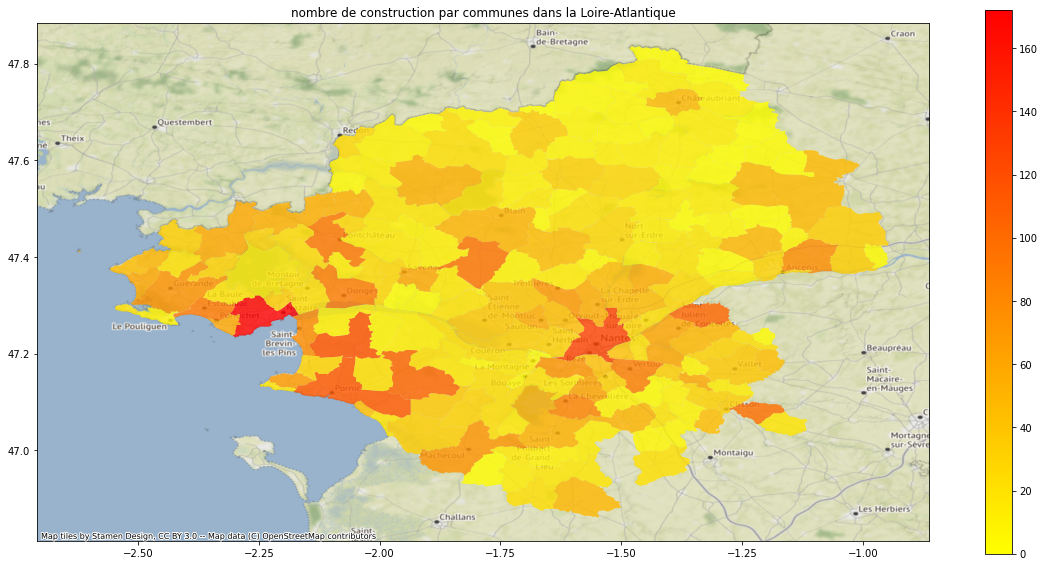

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax=dep_44.plot(ax=ax, column='Num_DAU',  cmap='autumn_r', legend=True, alpha=0.8,  legend_kwds={'shrink': 0.5})
plt.title("nombre de construction par communes dans la Loire-Atlantique")
cx.add_basemap(ax, crs=dep_44.crs)


In [36]:
dep_44.index=dep_44.libelle_long_norm
dep_44.index= dep_44.index.rename('commune')

### Nombre de nouvelles construction par nombre d'habitant

In [96]:
def com_code(code):
    if len(str(code))==1:
        code="00"+str(code)
    if len(str(code))==2:
        code="0"+str(code)
    code="44"+ str(code)
    return code
    

In [97]:
recensement_44=pd.read_csv('recensement_44_2022.csv', sep=';')

In [98]:
recensement_44['code_com']=recensement_44['Code commune'].apply(lambda x: com_code(x))

In [99]:
dep_44=dep_44.merge( recensement_44, left_on='code_insee', right_on='code_com', how='left')

In [100]:
dep_44['con_by_h']=dep_44['Num_DAU']/dep_44['Population totale']*100

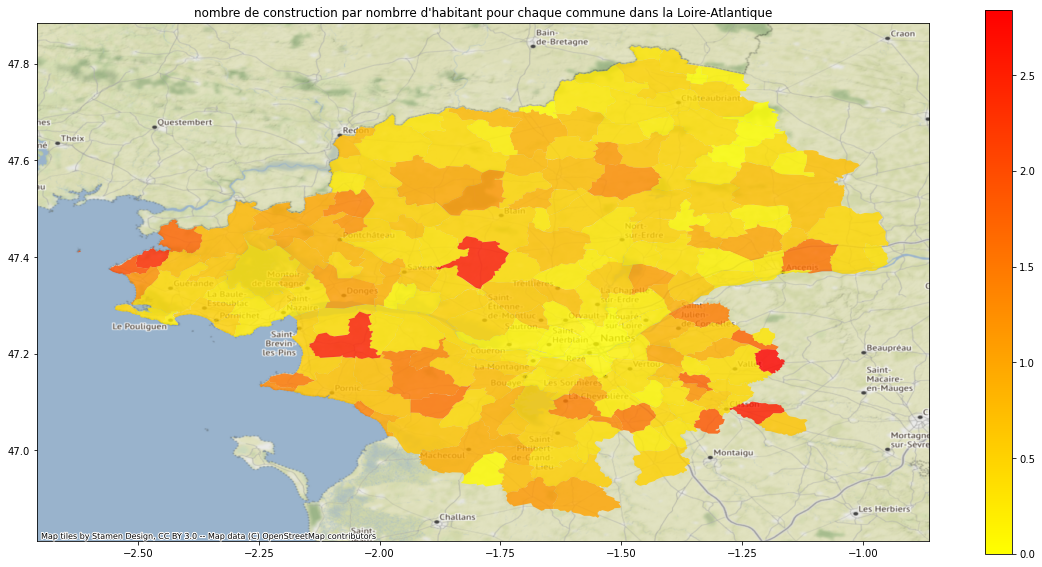

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax=dep_44.plot(ax=ax, column='con_by_h',  cmap='autumn_r', legend=True, alpha=0.8,  legend_kwds={'shrink': 0.5})
plt.title("nombre de construction par nombrre d'habitant pour chaque commune dans la Loire-Atlantique")
cx.add_basemap(ax, crs=dep_44.crs)

Il est difficile de tirer une conclusion et d'extraire des dynamiques territoriales avec une approche quantitative.
Nous allons donc utiliser l'indice de Moran local qui permet d'identifier les zones de cluster.
La démarche que nous allons suivre est tirée de deux sources:

-cette article de l'insee: https://www.insee.fr/fr/statistiques/fichier/3635442/imet131-g-chapitre-3.pdf

-et cette conférence D'Anselin, fondateur de l'économétrie spatiale: https://www.youtube.com/watch?v=d1WJNBwXfgo&list=PLzREt6r1Nenkr2vtYgbP4hs44HO_s_qEO&index=4


### indice de moran
<br>
### variable étudiée

#### creation d'un poid à partir du nombre d'habitant

<AxesSubplot:ylabel='Frequency'>

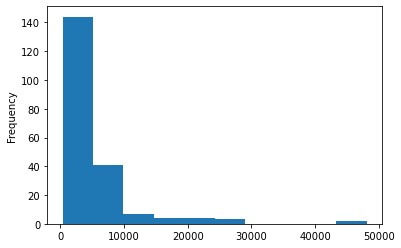

In [44]:
dep_44[dep_44['Population totale']<50000]['Population totale'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

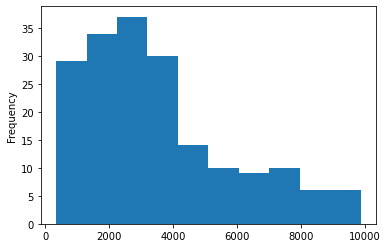

In [45]:
dep_44[dep_44['Population totale']<10000]['Population totale'].plot.hist()

In [46]:
def class_pop(pop):
    if pop > 50000:
        ponderation=4
    if pop < 50000 and pop <10000:
        ponderation=2
    if pop < 10000 and pop <5000:
        ponderation=1.5
    if pop < 5000 and pop <1000:
        ponderation=1.25
    else:
        ponderation=1
    return ponderation

In [47]:
dep_44['pond']=dep_44['Population totale'].apply(lambda x: class_pop(x))

## creation de la matrice de voisinage

#### preparation des donnees

In [48]:
##X
dep_44=dep_44.to_crs('EPSG:2154')

dep_44['X']=dep_44.geometry.centroid.x
dep_44['Y']=dep_44.geometry.centroid.x

dep_44=dep_44.to_crs('EPSG:4326')

In [49]:
centroid=np.column_stack((dep_44.X.tolist(),dep_44.Y.tolist()))

In [50]:
distance_matrix=scipy.spatial.distance_matrix(centroid, centroid, p=2, threshold=1000000)

#### stats matrix distance

In [51]:
d_matrix_wt_0 =[]

In [52]:
##distance_matrix([distance_matrix != 0])
for i in range(0, len(distance_matrix)):
    wt_0=list(filter(lambda x: x != 0, distance_matrix[i]))
    d_matrix_wt_0.append(wt_0)

In [53]:
stats_distance=pd.DataFrame([[max(x),min(x),np.mean(x),np.median(x),np.percentile(x,0.25),np.percentile(x,0.75)] for x in d_matrix_wt_0])

In [54]:
stats_distance.columns = ['max', 'min', 'mean', 'median', 'Q1', 'Q3']

In [55]:
stats_distance

,max,min,mean,median,Q1,Q3
0,149572.847826,220.890622,59743.485721,54074.443461,728.922161,1679.742769
1,151654.919213,2082.071386,61775.021394,56156.514848,2195.277830,2835.775574
2,112289.327800,16.109467,33668.347579,26071.410421,133.901953,293.196247
3,84112.607298,404.013729,32548.579995,30954.625310,606.486353,804.662383
4,101060.102987,119.504428,38796.705674,37538.914828,152.587074,842.144949
...,...,...,...,...,...,...
202,104535.887848,121.305884,31809.828238,25749.629655,249.507013,441.345008
203,119453.480121,119.791871,36506.802095,27751.807346,239.592358,400.583366
204,148193.052597,2843.627351,73521.999181,77406.239943,3331.663348,4287.938694
205,114623.043990,356.931156,46420.682916,45155.378517,409.491068,900.756325


<AxesSubplot:ylabel='Frequency'>

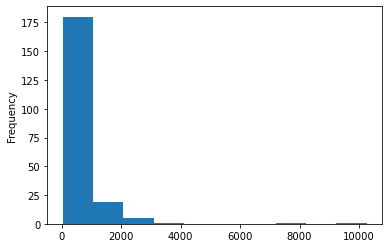

In [56]:
stats_distance.Q1.plot.hist()

In [57]:
mean_q1=np.mean(stats_distance.Q1)

In [58]:
np.mean(stats_distance['mean'])

42735.295201423156

In [59]:
min(stats_distance['max'])

83303.14341657308

#### plus proche voisin

In [60]:
tree=KDTree(centroid)

In [61]:
a,nei=tree.query(x=centroid, k=9, p=2)

In [62]:
nei_b=[]

In [63]:
for i in range(0, len(a)):
    print('LENGTH')
    print(len([x for x in a[i] if x <8000]))
    num_nei=len([x for x in a[i] if x <8000])
    print('num_nei')
    print(num_nei)
    print('NUM VOISIN')
    print(list(nei[i][0:num_nei]))
    nei_b.append(list(nei[i][0:num_nei]))
    
    

LENGTH
9
num_nei
9
NUM VOISIN
[0, 164, 149, 1, 40, 113, 187, 85, 179]
LENGTH
6
num_nei
6
NUM VOISIN
[1, 0, 164, 149, 40, 113]
LENGTH
9
num_nei
9
NUM VOISIN
[2, 80, 62, 50, 20, 141, 168, 59, 138]
LENGTH
9
num_nei
9
NUM VOISIN
[3, 125, 47, 15, 98, 30, 88, 198, 91]
LENGTH
9
num_nei
9
NUM VOISIN
[4, 144, 25, 167, 74, 128, 111, 161, 184]
LENGTH
9
num_nei
9
NUM VOISIN
[5, 165, 68, 44, 14, 154, 200, 133, 74]
LENGTH
9
num_nei
9
NUM VOISIN
[6, 193, 196, 119, 120, 78, 172, 49, 186]
LENGTH
9
num_nei
9
NUM VOISIN
[7, 107, 195, 178, 127, 171, 37, 131, 92]
LENGTH
9
num_nei
9
NUM VOISIN
[8, 151, 43, 190, 87, 160, 191, 188, 145]
LENGTH
9
num_nei
9
NUM VOISIN
[9, 106, 169, 41, 83, 86, 48, 159, 39]
LENGTH
9
num_nei
9
NUM VOISIN
[10, 129, 38, 126, 123, 188, 90, 122, 28]
LENGTH
9
num_nei
9
NUM VOISIN
[11, 139, 183, 53, 81, 108, 18, 91, 198]
LENGTH
8
num_nei
8
NUM VOISIN
[12, 199, 181, 166, 189, 112, 204, 147]
LENGTH
9
num_nei
9
NUM VOISIN
[13, 96, 177, 170, 73, 42, 121, 16, 100]
LENGTH
9
num_nei
9
NUM VOI

In [64]:
nei=nei_b

#### creation matrice plus proche voisin

In [65]:
Dict = {}

In [66]:
for i in range (0,len(nei)):
    dict_temp={}
    ###############print(nei[i][0])
    ###first element : it's hitself!
    a=nei[i][0]
    ###other element: real neighbors
    b=list(nei[i][1:])
    ###############print(b)
    ###key: itself, value: real neighbors
    dict_temp[a]=b
    Dict.update(dict_temp)


In [67]:
dict_w=dict(zip(dep_44.index,dep_44['pond']))

In [68]:
##v = 1.25
##dict_w = {k:v for k in dep_44.index}

In [69]:
dict_w_f={}

In [70]:
for k,v in Dict.items():
    ######print(k)
    #######print(v)
    ########print(type(v))
    ########print([dict_w[x] for x in v])
    temp=[dict_w[x] for x in v]
    dict_temp[k]=temp
    dict_w_f.update(dict_temp)

In [71]:
from libpysal.weights import W

In [72]:
##Dict

In [73]:
type(Dict)

dict

In [74]:
##dict_w_f

In [75]:
o=W(Dict, dict_w_f)


C:\Users\Thomas\Anaconda3\envs\spatial\lib\site-packages\libpysal\weights\weights.py:172: UserWarning:

The weights matrix is not fully connected: 
 There are 2 disconnected components.



In [76]:
y=dep_44['Num_DAU']

### matrice des plus proches voisins

In [77]:
Wq= ps.lib.weights.KNN.from_dataframe(dep_44, geom_col='geometry', k=20)

In [78]:
o[0]

{164: 1.25, 149: 1.0, 1: 1.0, 40: 1.0, 113: 1.25, 187: 1.25, 85: 1.0, 179: 1.0}

##calcul indice de moran global

In [79]:
m=ps.explore.esda.Moran(y, o)

In [80]:
m

### indice de moran global 

In [81]:
print('moran global')
print(m.I)

moran global
0.07514561614730285


### Indice de moran local

In [82]:
m_local=ps.explore.esda.Moran_Local(y,Wq, permutations=100000)

##valeurs locales de Moran

In [83]:
dep_44['index_moran_classe']=m_local.q
dep_44['index_moran']=m_local.Is

### test de l'hypothèse de randomisation 

In [84]:
if m.p_rand < 0.05:
    print('H0 st rejeté, il n y a pas de randomisation donc il y a autocorrelation globale')
    ##indique les clusters avec q la classe et p_sim la p_value
    dep_44['p_value']= m_local.p_sim
else :
    print('H0 est accepté, il y a randomisation donc il n y a pas autocorrelation globale')
    ##suit une loi normal
    dep_44['p_value']= m_local.p_z_sim*2

H0 st rejeté, il n y a pas de randomisation donc il y a autocorrelation globale


### False Discovery Rate

In [85]:
test=ps.explore.esda.fdr(dep_44['p_value'], 0.10)
dep_44['index_moran_cluster']=dep_44['index_moran_classe'].where(dep_44['p_value'] <= test).fillna(0)

### Cartographie des Clusters
(HH: high high, HL: High Low, LH: Low Hig, LL: Low Low)

In [86]:
maskHH= dep_44['index_moran_cluster'] ==np.intc(1.0)
maskLH= dep_44['index_moran_cluster'] ==np.intc(2.0)
maskLL= dep_44['index_moran_cluster'] ==np.intc(3.0)
maskHL= dep_44['index_moran_cluster'] ==np.intc(4.0)
maskother= dep_44['index_moran_cluster'] ==np.intc(0.0)

In [87]:
dep_44['index_moran_cluster']=dep_44['index_moran_cluster'].mask(maskHH, 'HH')
dep_44['index_moran_cluster']=dep_44['index_moran_cluster'].mask(maskLH, 'LH')
dep_44['index_moran_cluster']=dep_44['index_moran_cluster'].mask(maskLL, 'LL')
dep_44['index_moran_cluster']=dep_44['index_moran_cluster'].mask(maskHL, 'HL')
dep_44['index_moran_cluster']=dep_44['index_moran_cluster'].mask(maskother, 'non_significant')

dep_44['index_moran_cluster']


0                   HL
1      non_significant
2                   LL
3      non_significant
4      non_significant
            ...       
202                 LL
203                 LL
204                 HH
205    non_significant
206    non_significant
Name: index_moran_cluster, Length: 207, dtype: object

In [164]:
color_dict = {'LL':'#b82e2e', 'LH':'#FC6955', 'HL':'#3283FE', 
              'HH':'#1223e0', 'non_significant':'#bab0ac'}

In [165]:
dep_44['color']=dep_44['index_moran_cluster'].apply(lambda x: choose_color(x))

In [166]:
import matplotlib.colors as colors

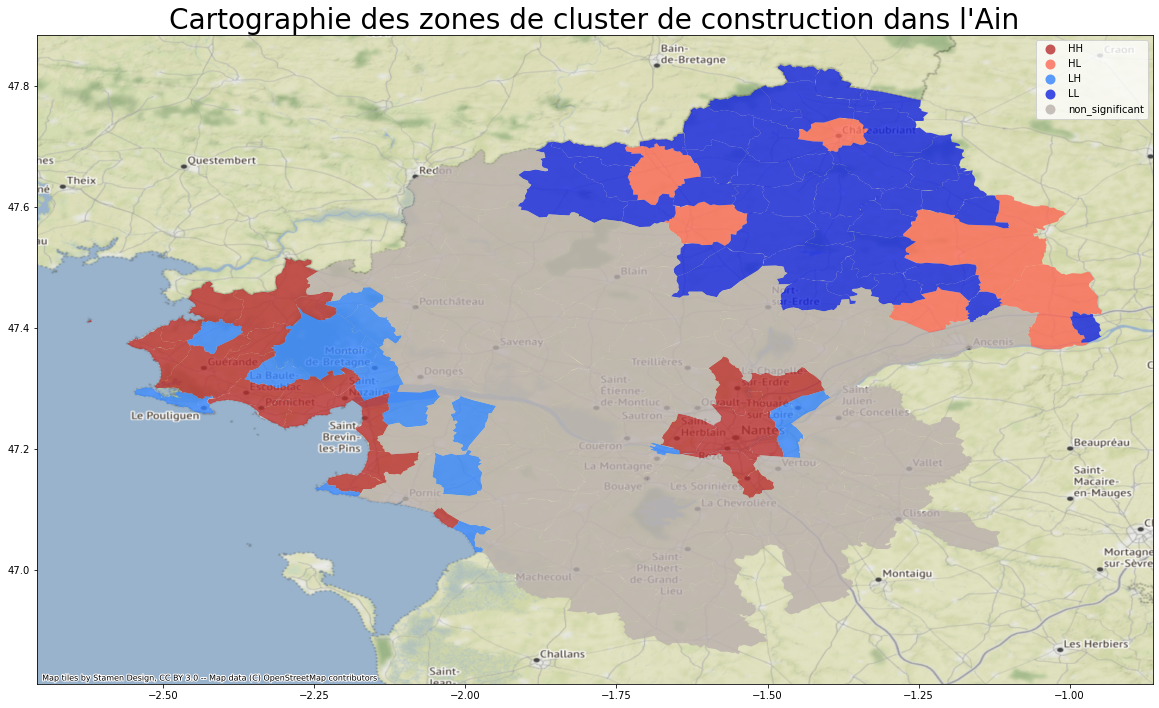

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax=dep_44.plot(ax=ax,column='index_moran_cluster',legend=True,alpha=0.8, legend_kwds={ 'bbox_to_anchor': (1, 1)},
              cmap=colors.ListedColormap(list(color_dict.values())))
plt.title("Cartographie des zones de cluster de construction dans l'Ain", fontdict={'fontsize': 28, 'fontweight': 'medium'})
cx.add_basemap(ax, crs=dep_44.crs)

##cx.add_basemap(ax, crs=dep_44.crs, source=cx.providers.CartoDB.Voyager)
##cx.add_basemap(ax, crs=dep_44.crs, source=cx.providers.Stamen.Terrain,zoom=12)
##cx.add_basemap(ax, crs=dep_44.crs,source=cx.providers.Stamen.TonerLabels, zoom=9)

In [151]:
dep_44=dep_44.sort_values("index_moran_cluster")

## En conclusion


## Discussion

Notre étude est limitée car elle prend uniquement en compte les constructions alors que l'étude de l'extension urbaine ne se réduit pas uniquement à ce prisme.
En effet beaucoup d'autres facteurs rentrent en compte: l'augmentation du prix du mètre carré, le type de construction (immeuble ou maison par exemple), l'évoultion sociologique des populations...